In [1]:
import os, sys

# find repo root (looks for liars_poker/ or pyproject.toml)
def find_repo_root(start_dir: str) -> str:
    cur = os.path.abspath(start_dir)
    for _ in range(6):
        if os.path.isdir(os.path.join(cur, "liars_poker")) or os.path.exists(os.path.join(cur, "pyproject.toml")):
            return cur
        parent = os.path.dirname(cur)
        if parent == cur:
            break
        cur = parent
    return os.path.abspath(os.path.join(start_dir, "..", ".."))

NB_DIR = os.getcwd()
REPO_ROOT = find_repo_root(NB_DIR)
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

ARTIFACTS_ROOT = os.path.join(REPO_ROOT, "artifacts")
os.makedirs(ARTIFACTS_ROOT, exist_ok=True)

print("repo root   :", REPO_ROOT)
print("artifacts   :", ARTIFACTS_ROOT)


repo root   : c:\Users\adidh\Documents\liars_poker
artifacts   : c:\Users\adidh\Documents\liars_poker\artifacts


In [6]:
from liars_poker import (
    GameSpec, Env, InfoSet, Rules,
    Policy, TabularPolicy, CommitOnceMixture, RandomPolicy,
    eval_both_seats
)

from liars_poker.training.fsp import fsp_loop, fsp_loop_tabular_only
from liars_poker.algo.br_exact_efficient import best_response_exact as best_response_efficient
from liars_poker.algo.br_exact import best_response_exact
from liars_poker.algo.br_mc import best_response_mc
from liars_poker.algo.br_exact_dense import best_response_dense
from liars_poker.algo.br_exact_dense_to_dense import best_response_exact as best_response_denser

from liars_poker.core import possible_starting_hands
from liars_poker.policies.tabular_dense import DenseTabularPolicy

In [3]:
CALL = -1
def enumerate_claim_histories(k: int):
    """
    Enumerate all nonterminal claim-only histories (strictly increasing tuples),
    excluding CALL. Includes empty history ().
    Total = 2^k.
    """
    # Use bitmask enumeration; produces sorted tuples by construction
    for hid in range(1 << k):
        hist = tuple(i for i in range(k) if (hid >> i) & 1)
        yield hist


class AlwaysRaiseProbs(TabularPolicy):
    POLICY_KIND = "AlwaysRaiseProbs"

    def __init__(self, rules: Rules):
        super().__init__()
        self.bind_rules(rules)
        self._materialize()

    def _materialize(self):
        rules = self._rules
        spec = rules.spec
        hands = possible_starting_hands(spec)
        k = len(rules.claims)

        for history in enumerate_claim_histories(k):
            pid = len(history) % 2
            for hand in hands:
                iset = InfoSet(pid=pid, hand=hand, history=history)
                legal = rules.legal_actions_for(iset)
                if not legal:
                    continue
                raise_only = [a for a in legal if a != CALL]
                if raise_only:
                    self.set(iset, {min(raise_only): 1.0})
                else:
                    self.set(iset, {CALL: 1.0})

In [5]:
from typing import Dict, Tuple, List, Callable, Optional, Iterable

In [24]:
spec = GameSpec(ranks=7, suits=4, hand_size=2, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True)
rules = Rules(spec)

In [13]:
from liars_poker.policies.tabular_dense import mix_dense
import random
import scipy.stats as stats

In [22]:
def basic_eta_control(episodes: int) -> float:
    return 1 / (episodes + 2)


def dense_fsp_loop(
    spec: GameSpec,
    episodes: int,
    *,
    initial_pol: Optional[Policy | None] = None, 
    eta_control: Optional[Callable[[int], float]] | None = None,
    episodes_test: Optional[int] = 10_000,
    debug: bool = False

) -> Tuple[TabularPolicy, Dict]:
    if initial_pol is None:
        initial_pol = DenseTabularPolicy(spec)

    if eta_control is None:
        eta_control = basic_eta_control

    if episodes_test is None:
        episodes_test = 100

    rules = Rules(spec)
    initial_pol.bind_rules(rules)

    all_averages = [initial_pol]
    curr_av = initial_pol

    exploitability_series, p_values = [], []
    for i in range(episodes):

        print(i)

        eta = eta_control(i)

        b_i, br_computer = best_response_denser(spec=spec, policy=curr_av, debug=False)
        p_first, p_second = br_computer.exploitability()
        predicted = 0.5 * (p_first + p_second)

        eval_results = eval_both_seats(spec, b_i, curr_av, episodes=episodes_test, seed=random.randint(1,1000))
        observed_rate = eval_results['P1']

        expected_successes = episodes_test * predicted
        expected_failures = episodes_test * (1 - predicted)
        observed_failures = episodes_test * (1 - observed_rate)

        chi2_stat = 0.0
        if expected_successes > 0 and expected_failures > 0:
            chi2_stat = (((episodes_test*observed_rate) - expected_successes) ** 2) / expected_successes + ((observed_failures - expected_failures) ** 2) / expected_failures
        p_value = 1 - stats.chi2.cdf(chi2_stat, 1)

        exploitability_series.append({'P1': p_first, 'P2': p_second})
        p_values.append(p_value)

        print(f"Predicted exploitability: avg={predicted:.4f} (first={p_first:.4f}, second={p_second:.4f})")
        print(f"Sampled exploitability: avg={observed_rate:.4f}, chi2 p-value={p_value:.4g}")
        print()

        curr_av = mix_dense(b_i, curr_av, eta)
    all_averages.append(curr_av)

    return curr_av, {'exploitability_series': exploitability_series, 'p_values': p_values}

    



    

In [27]:
answer, debug = dense_fsp_loop(spec, 3000)

0
Predicted exploitability: avg=0.9193 (first=0.9265, second=0.9120)
Sampled exploitability: avg=0.9173, chi2 p-value=0.4695

1
Predicted exploitability: avg=0.8191 (first=0.8293, second=0.8089)
Sampled exploitability: avg=0.8223, chi2 p-value=0.3996

2
Predicted exploitability: avg=0.7797 (first=0.8251, second=0.7343)
Sampled exploitability: avg=0.7768, chi2 p-value=0.4827

3
Predicted exploitability: avg=0.7424 (first=0.7587, second=0.7261)
Sampled exploitability: avg=0.7432, chi2 p-value=0.8509

4
Predicted exploitability: avg=0.7299 (first=0.7474, second=0.7124)
Sampled exploitability: avg=0.7291, chi2 p-value=0.8515

5
Predicted exploitability: avg=0.7224 (first=0.7463, second=0.6985)
Sampled exploitability: avg=0.7197, chi2 p-value=0.5492

6
Predicted exploitability: avg=0.7219 (first=0.7524, second=0.6914)
Sampled exploitability: avg=0.7200, chi2 p-value=0.67

7
Predicted exploitability: avg=0.7105 (first=0.7271, second=0.6938)
Sampled exploitability: avg=0.7154, chi2 p-value=0.

In [20]:
# answer, debug = fsp_loop(spec, best_response_exact, 100, episodes_test=1, initial_pol=AlwaysRaiseProbs(rules))

In [21]:
# answer, debug = fsp_loop_tabular_only(spec, best_response_dense, 10, episodes_test=1, initial_pol=AlwaysRaiseProbs(rules))

In [ ]:
# answer1, info1 = fsp_loop(spec, best_response_efficient, 300, episodes_test=1)

Predicted exploitability: avg=0.8841 (first=0.9063, second=0.8619)
Sampled exploitability: avg=0.0000, chi2 p-value=0.005753

Predicted exploitability: avg=0.8022 (first=0.8183, second=0.7861)
Sampled exploitability: avg=0.0000, chi2 p-value=0.04401

Predicted exploitability: avg=0.7358 (first=0.8167, second=0.6549)
Sampled exploitability: avg=1.0000, chi2 p-value=0.549

Predicted exploitability: avg=0.6935 (first=0.7792, second=0.6079)
Sampled exploitability: avg=0.0000, chi2 p-value=0.1325

Predicted exploitability: avg=0.6548 (first=0.7300, second=0.5796)
Sampled exploitability: avg=1.0000, chi2 p-value=0.4678

Predicted exploitability: avg=0.6405 (first=0.7203, second=0.5608)
Sampled exploitability: avg=1.0000, chi2 p-value=0.4538

Predicted exploitability: avg=0.6385 (first=0.7221, second=0.5548)
Sampled exploitability: avg=0.0000, chi2 p-value=0.1839

Predicted exploitability: avg=0.6298 (first=0.6913, second=0.5683)
Sampled exploitability: avg=1.0000, chi2 p-value=0.4432

Predic

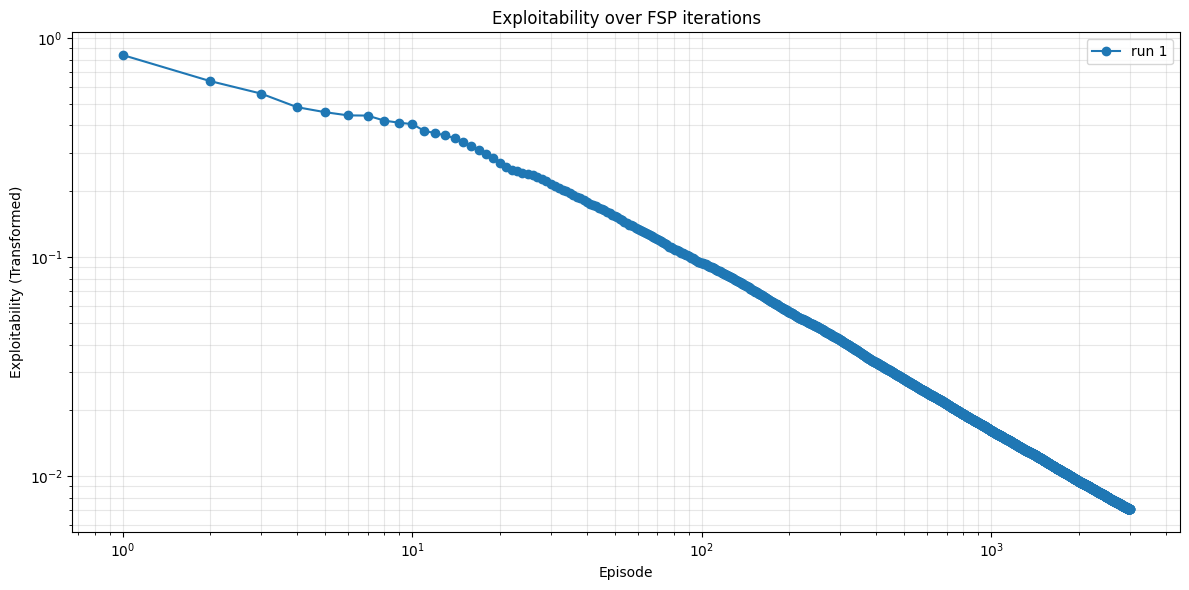

In [28]:
from liars_poker.training.fsp import plot_exploitability_series
ax = plot_exploitability_series([debug], average=True, figsize=(12, 6), transform=True)
# or plot_exploitability_series(info, avera
# ge=False)


In [34]:
from liars_poker.policies.tabular_dense import DenseTabularPolicy
from liars_poker.serialization import register_policy, save_policy

# One-time registration in this kernel
register_policy(DenseTabularPolicy)

# Now save your existing dense policy instance `pol`
save_policy(answer, save_dir)


NotImplementedError: 

[0.4192703331908403,
 0.31905759675454404,
 0.2797089651912401,
 0.24237793385933926,
 0.22993106960807896,
 0.22238232027635307,
 0.2219096368301101,
 0.21048099036659862,
 0.20585494060240817,
 0.20290814919130162,
 0.18885531077630724,
 0.18455460073861052,
 0.18014598114387392,
 0.1750157252280593,
 0.16836671747731347,
 0.16194172780620675,
 0.15515660770256545,
 0.14851846165809035,
 0.141614207807798,
 0.13530820327319593,
 0.12930707883398473,
 0.12565501069709428,
 0.12358089348849566,
 0.12149711837404475,
 0.12036284131649588,
 0.11843635139284192,
 0.11662909167486601,
 0.11364052743841302,
 0.11134427521243317,
 0.10859223141285379,
 0.10561301644055299,
 0.10348591545036845,
 0.1017311891408531,
 0.099962116666384,
 0.09821752023693309,
 0.09640331348341458,
 0.09479504510563053,
 0.09288921529385563,
 0.09102116879916466,
 0.08955268721867427,
 0.08803634706245023,
 0.08655025740772326,
 0.08550172440958714,
 0.08405015153089368,
 0.08281905551974833,
 0.0818921538834749

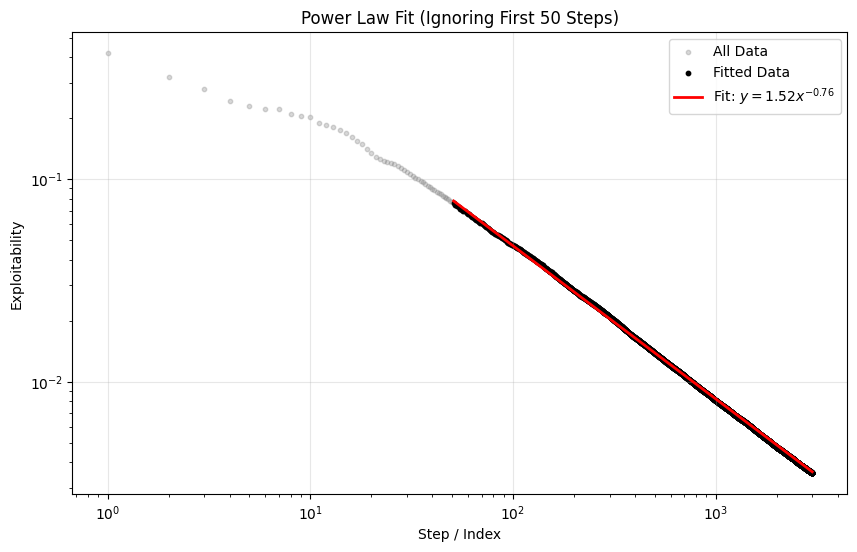

Equation: y = 1.5225 * x^-0.7556


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- power law model ---
def power_law(x, a, b):
    return a * np.power(x, b)

# --- parameters ---
burn_in = 50  # number of initial points to ignore

# --- data ---
y_data = np.array([(i['P1'] + i['P2'] - 1) / 2 for i in debug['exploitability_series']])
x_data = np.arange(len(y_data)) + 1  # steps start at 1 (important for log scale)

# --- slice for fitting ---
x_fit_data = x_data[burn_in:]
y_fit_data = y_data[burn_in:]

# --- fit ---
pars, cov = curve_fit(power_law, x_fit_data, y_fit_data)

# --- smooth fit curve ---
x_fit = np.linspace(x_fit_data.min(), x_fit_data.max(), 300)
y_fit = power_law(x_fit, *pars)

# --- plot ---
plt.figure(figsize=(10, 6))

plt.scatter(x_data, y_data, color='gray', alpha=0.3, s=10, label='All Data')
plt.scatter(x_fit_data, y_fit_data, color='black', s=10, label='Fitted Data')

plt.plot(
    x_fit, y_fit,
    color='red', linewidth=2,
    label=f'Fit: $y = {pars[0]:.2f}x^{{{pars[1]:.2f}}}$'
)

plt.xlabel('Step / Index')
plt.ylabel('Exploitability')
plt.title(f'Power Law Fit (Ignoring First {burn_in} Steps)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.show()

print(f"Equation: y = {pars[0]:.4f} * x^{pars[1]:.4f}")


In [30]:
from liars_poker.serialization import save_policy
save_dir = "C:/Users/adidh/Documents/liars_poker/artifacts/my_test_policy_10"

# 3. Save
# This will create 'policy.npz' (heavy data) and 'spec.json' (metadata) inside the folder
# save_policy(answer, save_dir)